In [1]:
import pandas as pd
from sacremoses import MosesTokenizer, MosesDetokenizer
from sklearn.model_selection import train_test_split
from pathlib import Path
import re, gzip, os, pickle

In [2]:
# 1. 路径设置
SENT_CSV = r"D:\AI\TRANSFORMER\sentences.csv"
LINK_CSV = r"D:\AI\TRANSFORMER\links.csv"
SAVE_DIR = Path(r"D:\AI\TRANSFORMER\tatoeba_enzh_clean")   # 输出目录
SAVE_DIR.mkdir(exist_ok=True)

In [ ]:
# 2. 读取原始表
print("Loading sentences...")
sent = pd.read_csv(SENT_CSV, sep="\t", header=None,
                   names=["sent_id", "lang", "text"])

# 3. 抽英文和中文
print("Filtering English & Chinese...")
en = sent[sent.lang == "eng"].copy()
zh = sent[sent.lang == "cmn"].copy()        # Tatoeba 用 cmn 表示简体中文
print(f"EN: {len(en)}, ZH: {len(zh)}")

In [ ]:
# 4. 读取关联表
print("Loading links...")
links = pd.read_csv(LINK_CSV, sep="\t", header=None,
                    names=["left", "right"])

# 5. 建索引 -> 快速匹配
en_idx = en.set_index("sent_id")
zh_idx = zh.set_index("sent_id")

In [ ]:
from tqdm import tqdm
# 6. 找出互为翻译的 (en_id, zh_id) 对
pairs = []
for row in tqdm(links.itertuples(index=False), total=len(links), desc="Finding EN-ZH pairs"):
    l, r = row.left, row.right      # 用字段名
    if l in en_idx.index and r in zh_idx.index:
        pairs.append((l, r))
    elif r in en_idx.index and l in zh_idx.index:
        pairs.append((r, l))

print(f"Raw pairs: {len(pairs)}")

In [ ]:
# 7. 转成 DataFrame
df = pd.DataFrame(pairs, columns=["en_id", "zh_id"])
df["en"] = df.en_id.map(en_idx.text)
df["zh"] = df.zh_id.map(zh_idx.text)

# 8. 基础清洗函数
mt_en = MosesTokenizer(lang="en")
mt_zh = MosesTokenizer(lang="zh")
def clean_en(s):
    if pd.isna(s): return None
    s = str(s).strip()
    if not s: return None
    # 去掉 html 标签、控制字符
    s = re.sub(r"<[^>]+>", "", s)
    s = re.sub(r"[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]", "", s)
    # 去掉纯数字/网址/过长
    if re.fullmatch(r"\d+", s): return None
    if "http" in s or "www." in s: return None
    if len(s) > 300: return None
    return " ".join(mt_en.tokenize(s, escape=False))

def clean_zh(s):
    if pd.isna(s): return None
    s = str(s).strip()
    if not s: return None
    s = re.sub(r"<[^>]+>", "", s)
    s = re.sub(r"[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]", "", s)
    # 去掉纯数字/过长
    if re.fullmatch(r"[0-9\s\W]+", s): return None
    if len(s) > 300: return None
    # 可选：全角转半角、统一标点
    return " ".join(mt_zh.tokenize(s, escape=False))

In [ ]:
# 9. 并行清洗
print("Cleaning...")
df["en_clean"] = df.en.apply(clean_en)
df["zh_clean"] = df.zh.apply(clean_zh)

# 去掉任何一边清洗后为空
df = df.dropna(subset=["en_clean", "zh_clean"])
print(f"After cleaning: {len(df)}")

In [ ]:
# 10. 去重（按文本）
df = df.drop_duplicates(subset=["en_clean", "zh_clean"])
print(f"After dedup: {len(df)}")

# 11. 过滤明显质量差的
def ratio_ok(a, b):
    # 长度比例 1:5 ~ 5:1
    r = len(a) / (len(b) + 1e-6)
    return 0.2 <= r <= 5

mask = df.apply(lambda x: ratio_ok(x.en_clean, x.zh_clean), axis=1)
df = df[mask]
print(f"After ratio filter: {len(df)}")

In [ ]:
# 12. 划分训练/验证/测试
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val  = train_test_split(train, test_size=0.1, random_state=42)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

In [ ]:
# 13. 保存
def save_split(split_df, name):
    out = SAVE_DIR / f"{name}.tsv"
    split_df[["en_clean", "zh_clean"]].to_csv(out, sep="\t", index=False, header=False)
    print(f"{name} saved to {out}")

save_split(train, "train")
save_split(val,   "val")
save_split(test,  "test")

In [ ]:
# 14. 可选：BPE/Subword 词典预处理
# -------------------------------------------------
# 这里给出用 HuggingFace tokenizers 训练 BPE 的最小示例
# 如果不需要可直接跳过
if True:   # 改成 True 即可跑
    from tokenizers import Tokenizer, models, pre_tokenizers, trainers
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=32000,
        special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
    )

    files = [str(SAVE_DIR / "train.tsv")]
    tokenizer.train(files, trainer)

    tokenizer.save(str(SAVE_DIR / "tokenizer.json"))
    print("BPE tokenizer saved.")

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 120)   # 让句子别被截断

train = pd.read_csv(r"D:\AI\TRANSFORMER\tatoeba_enzh_clean\train.tsv",
                    sep="\t", header=None, names=["en", "zh"])

print("前 5 行：")
print(train.head())

print("\n随机 5 行：")
print(train.sample(5))

print("\n统计信息：")
print(train.describe(include='all'))

前 5 行：
                                                        en            zh
0                               I don 't want to see you .       我不想看到你。
1  As usual the peasants are busy scattering grain seeds .   農民們如常在忙著播種。
2               He doesn 't know anything about the plan .  关于计划他什么也不知道。
3                                Your back door was open .     你的后门是开着的。
4                            The fire went out by itself .       火自然熄滅了。

随机 5 行：
                                  en          zh
4491      Five plus three is eight .     五加三等於八。
52876           No music , no life .  沒音樂 ， 沒生活。
55981  I want to share it with you .    我想跟你分享吧。
55934                   I hate you .        我恨你。
51789                   I love her .        我爱她。

统计信息：
                               en       zh
count                       56366    56366
unique                      53234    49193
top     I 'll help you if I can .  他要做什麼 ？
freq                           10       16


In [10]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

bpe_path = r"D:\AI\TRANSFORMER\bpe.json"
bpe_vocab = 32000

# 1-1 准备语料文件
with open("tatoeba_enzh_clean/train.tsv", encoding="utf-8") as f:
    corpus = [line.rstrip("\n").split("\t")[0] + " " + line.rstrip("\n").split("\t")[1]
              for line in f]

with open("corpus_for_bpe.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(corpus))

# 1-2 训练 BPE
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=bpe_vocab,
                              special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"])
tokenizer.train(["corpus_for_bpe.txt"], trainer)
tokenizer.save(bpe_path)
print("BPE 训练完成，已保存到", bpe_path)

BPE 训练完成，已保存到 D:\AI\TRANSFORMER\bpe.json


In [4]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import os

In [5]:
# 设置随机种子保证可复现性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
# 1. 位置编码层
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)   # 偶数维
        pe[:, 1::2] = torch.cos(position * div_term)   # 奇数维
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)



In [7]:
# 2. 带注意力追踪的编码器层
class TransformerEncoderLayerWithTrace(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # src: (batch, seq, d_model)
        src2, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True
        )
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights


In [8]:
# 3. 微型Transformer编码器
class TinyTransformer(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayerWithTrace(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src
        attn_weights_list = []
        for layer in self.layers:
            output, attn_weights = layer(
                output, src_mask=mask, src_key_padding_mask=src_key_padding_mask
            )
            attn_weights_list.append(attn_weights)
        return output, attn_weights_list

In [9]:
# 4. 解码器层
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        self.multihead_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # tgt: (batch, tgt_seq, d_model) ; memory: (batch, src_seq, d_model)
        tgt2, self_attn_weights = self.self_attn(
            tgt, tgt, tgt,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=True
        )
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        tgt2, cross_attn_weights = self.multihead_attn(
            tgt, memory, memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
            need_weights=True
        )
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt, self_attn_weights, cross_attn_weights


In [10]:
# 5. Transformer解码器
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        output = tgt
        self_attn_list, cross_attn_list = [], []
        for layer in self.layers:
            output, self_attn, cross_attn = layer(
                output, memory,
                tgt_mask=tgt_mask, memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )
            self_attn_list.append(self_attn)
            cross_attn_list.append(cross_attn)
        return output, self_attn_list, cross_attn_list


In [11]:
# 6. 完整的Seq2Seq模型
class TinyTransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead,
                 num_encoder_layers, num_decoder_layers, dim_feedforward,
                 max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_len)
        self.pos_decoder = PositionalEncoding(d_model, dropout, max_seq_len)

        self.encoder = TinyTransformer(num_encoder_layers, d_model, nhead, dim_feedforward, dropout)
        self.decoder = TransformerDecoder(num_decoder_layers, d_model, nhead, dim_feedforward, dropout)

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def encode(self, src, src_mask=None, src_key_padding_mask=None):
        # src: (batch, src_seq)
        src_emb = self.src_embed(src) * math.sqrt(self.d_model)     # (batch, src_seq, d_model)
        src_emb = self.pos_encoder(src_emb)
        memory, enc_attn_weights = self.encoder(
            src_emb, mask=src_mask, src_key_padding_mask=src_key_padding_mask
        )
        return memory, enc_attn_weights

    def decode(self, tgt, memory, tgt_mask=None, memory_mask=None,
               tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # tgt: (batch, tgt_seq)
        tgt_emb = self.tgt_embed(tgt) * math.sqrt(self.d_model)     # (batch, tgt_seq, d_model)
        tgt_emb = self.pos_decoder(tgt_emb)
        output, self_attn, cross_attn = self.decoder(
            tgt_emb, memory,
            tgt_mask=tgt_mask, memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        logits = self.fc_out(output)                                # (batch, tgt_seq, vocab)
        return logits, self_attn, cross_attn

    def forward(self, src, tgt, src_mask=None, tgt_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None):
        memory, _ = self.encode(src, src_mask, src_key_padding_mask)
        output, _, _ = self.decode(
            tgt, memory, tgt_mask, None, tgt_key_padding_mask, src_key_padding_mask
        )
        return output  # (batch, tgt_seq, vocab)

In [12]:
# 7. 序列到序列数据集（处理TSV文件）
class Seq2SeqDataset(Dataset):
    def __init__(self, tsv_path, tokenizer, max_len=50):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.bos_token_id = tokenizer.token_to_id("<bos>")
        self.eos_token_id = tokenizer.token_to_id("<eos>")
        self.pad_token_id = tokenizer.token_to_id("<pad>")
        self.data = []

        with open(tsv_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    continue
                en_sent = parts[0].strip()
                zh_sent = parts[1].strip()

                en_enc = tokenizer.encode(en_sent)
                zh_enc = tokenizer.encode(zh_sent)

                en_ids = [self.bos_token_id] + en_enc.ids[:max_len - 2] + [self.eos_token_id]
                zh_ids = [self.bos_token_id] + zh_enc.ids[:max_len - 2] + [self.eos_token_id]

                en_ids = en_ids + [self.pad_token_id] * (max_len - len(en_ids))
                zh_ids = zh_ids + [self.pad_token_id] * (max_len - len(zh_ids))

                self.data.append((torch.tensor(en_ids, dtype=torch.long),
                                  torch.tensor(zh_ids, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [13]:
# 8. 生成自回归掩码
def generate_subsequent_mask(sz):
    # (tgt_len, tgt_len)，True 表示被mask
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)
    return mask

# 9. 训练函数
def train_one_epoch(model, dataloader, optimizer, criterion, clip, device, tokenizer):
    model.train()
    epoch_loss = 0.0

    pad_id = tokenizer.token_to_id("<pad>")

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)

        # Teacher Forcing：tgt_input 右移一位
        tgt_input = tgt[:, :-1]                   # (batch, T-1)
        tgt_output = tgt[:, 1:]                   # (batch, T-1)

        tgt_mask = generate_subsequent_mask(tgt_input.size(1)).to(device)  # (T-1, T-1)
        src_padding_mask = (src == pad_id)        # (batch, src_len)
        tgt_padding_mask = (tgt_input == pad_id)  # (batch, tgt_len-1)

        optimizer.zero_grad()

        logits = model(
            src, tgt_input,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )  # (batch, T-1, vocab)

        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_output.reshape(-1)
        )
        loss.backward()

        if clip is not None and clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [14]:
import torch
import torch.nn.functional as F

def beam_search_decode(model, src, max_len, device, tokenizer, beam_size=5):
    model.eval()
    src = src.unsqueeze(0).to(device) if src.dim() == 1 else src.to(device)

    with torch.no_grad():
        memory, _ = model.encode(src)  # (1, src_len, d_model)

        # 初始候选序列：[batch=1, 1]
        bos_id = tokenizer.token_to_id("<bos>")
        eos_id = tokenizer.token_to_id("<eos>")
        sequences = [(torch.tensor([[bos_id]], device=device), 0.0)]  # (tokens, score)

        for _ in range(max_len - 1):
            all_candidates = []
            for seq, score in sequences:
                if seq[0, -1].item() == eos_id:
                    # 如果已到 <eos>，直接保留
                    all_candidates.append((seq, score))
                    continue

                tgt_mask = generate_subsequent_mask(seq.size(1)).to(device)
                out, _, _ = model.decode(seq, memory, tgt_mask=tgt_mask)
                prob = F.log_softmax(out[:, -1, :], dim=-1)  # log 概率

                # 取 top-k
                topk_scores, topk_ids = prob.topk(beam_size, dim=-1)
                for i in range(beam_size):
                    next_token = topk_ids[0, i].unsqueeze(0).unsqueeze(0)  # (1,1)
                    new_seq = torch.cat([seq, next_token], dim=1)
                    new_score = score + topk_scores[0, i].item()
                    all_candidates.append((new_seq, new_score))

            # 选出分数最高的 beam_size 个候选
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]

        # 返回得分最高的序列
        best_seq = sequences[0][0]
    return best_seq


In [15]:
# 11. 验证函数
def evaluate(model, dataloader, criterion, device, tokenizer):
    model.eval()
    epoch_loss = 0.0
    pad_id = tokenizer.token_to_id("<pad>")

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_mask = generate_subsequent_mask(tgt_input.size(1)).to(device)
            src_padding_mask = (src == pad_id)
            tgt_padding_mask = (tgt_input == pad_id)

            logits = model(
                src, tgt_input,
                src_key_padding_mask=src_padding_mask,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_output.reshape(-1)
            )
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [17]:

from tqdm import tqdm

# 主函数
if __name__ == "__main__":
    # ----- 超参数 -----
    BPE_PATH = r"D:\AI\TRANSFORMER\bpe.json"
    TRAIN_TSV = r"D:\AI\TRANSFORMER\tatoeba_enzh_clean\train.tsv"
    VALID_TSV = r"D:\AI\TRANSFORMER\tatoeba_enzh_clean\val.tsv"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 模型
    D_MODEL = 256
    NHEAD = 8
    NUM_ENCODER_LAYERS = 3
    NUM_DECODER_LAYERS = 3
    DIM_FEEDFORWARD = 512
    DROPOUT = 0.5          # 适度提高 Dropout（防过拟合）
    MAX_LEN = 50

    # 优化与训练
    BATCH_SIZE = 64
    NUM_EPOCHS = 20
    LR = 5e-4
    CLIP = 1.0
    WEIGHT_DECAY = 1e-2    # AdamW 权重衰减（防过拟合）
    LABEL_SMOOTH = 0.1     # 标签平滑（防过拟合）
    PATIENCE = 5           # Early Stopping 耐心
    LR_FACTOR = 0.3        # Plateau 降学习率倍数
    LR_PATIENCE = 2        # 几个 epoch 无提升就降 LR
    MIN_LR = 1e-6

    # ----- Tokenizer & Vocab -----
    tokenizer = Tokenizer.from_file(BPE_PATH)
    vocab_size = tokenizer.get_vocab_size()
    pad_id = tokenizer.token_to_id("<pad>")

    # ----- 数据 -----
    train_dataset = Seq2SeqDataset(TRAIN_TSV, tokenizer, MAX_LEN)
    valid_dataset = Seq2SeqDataset(VALID_TSV, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # ----- 模型 -----
    model = TinyTransformerSeq2Seq(
        vocab_size, vocab_size, D_MODEL, NHEAD,
        NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
        DIM_FEEDFORWARD, MAX_LEN, DROPOUT
    ).to(DEVICE)

    # ----- 优化器 / 调度器 / 损失 -----
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=LR_FACTOR,
        patience=LR_PATIENCE,
        min_lr=MIN_LR
    )
    criterion = nn.CrossEntropyLoss(
        ignore_index=pad_id, label_smoothing=LABEL_SMOOTH
    )

    # ----- 训练循环（含 Early Stopping）-----
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    print(f"开始训练... 设备: {DEVICE}")
    print(f"训练集大小: {len(train_dataset)} | 验证集大小: {len(valid_dataset)}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # 训练阶段（进度条）
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", unit="batch") as pbar:
            epoch_train_loss = 0.0
            model.train()
            for src, tgt in pbar:
                src, tgt = src.to(DEVICE), tgt.to(DEVICE)

                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]

                tgt_mask = generate_subsequent_mask(tgt_input.size(1)).to(DEVICE)
                src_padding_mask = (src == pad_id)
                tgt_padding_mask = (tgt_input == pad_id)

                optimizer.zero_grad()
                logits = model(
                    src, tgt_input,
                    src_key_padding_mask=src_padding_mask,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_padding_mask
                )
                loss = criterion(
                    logits.reshape(-1, logits.size(-1)),
                    tgt_output.reshape(-1)
                )
                loss.backward()
                if CLIP is not None and CLIP > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
                optimizer.step()

                epoch_train_loss += loss.item()
                pbar.set_postfix(loss=f"{loss.item():.3f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

            train_loss = epoch_train_loss / len(train_loader)

        # 验证阶段（进度条）
        with tqdm(valid_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]", unit="batch") as pbar:
            model.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for src, tgt in pbar:
                    src, tgt = src.to(DEVICE), tgt.to(DEVICE)
                    tgt_input = tgt[:, :-1]
                    tgt_output = tgt[:, 1:]

                    tgt_mask = generate_subsequent_mask(tgt_input.size(1)).to(DEVICE)
                    src_padding_mask = (src == pad_id)
                    tgt_padding_mask = (tgt_input == pad_id)

                    logits = model(
                        src, tgt_input,
                        src_key_padding_mask=src_padding_mask,
                        tgt_mask=tgt_mask,
                        tgt_key_padding_mask=tgt_padding_mask
                    )
                    loss = criterion(
                        logits.reshape(-1, logits.size(-1)),
                        tgt_output.reshape(-1)
                    )
                    epoch_val_loss += loss.item()
                    pbar.set_postfix(loss=f"{loss.item():.3f}")

            valid_loss = epoch_val_loss / len(valid_loader)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        print(f"Epoch {epoch+1:02} | 用时: {int(epoch_mins)}分{int(epoch_secs)}秒")
        print(f"\t训练损失: {train_loss:.3f} | 验证损失: {valid_loss:.3f}")

        # 学习率调度（根据验证损失）
        scheduler.step(valid_loss)

        # Early Stopping & 保存最佳
        if valid_loss < best_valid_loss - 1e-6:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_transformer_model.pt')
            print(f"✓ 保存新的最佳模型，验证损失: {valid_loss:.3f}")
        else:
            epochs_no_improve += 1
            print(f"验证集未提升：{epochs_no_improve}/{PATIENCE}")
            if epochs_no_improve >= PATIENCE:
                print("早停触发，结束训练。")
                break

开始训练... 设备: cuda
训练集大小: 56366 | 验证集大小: 6263


Epoch 1/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:01<00:00, 56.45batch/s, loss=6.530]


Epoch 01 | 用时: 1分8秒
	训练损失: 7.082 | 验证损失: 6.662
✓ 保存新的最佳模型，验证损失: 6.662


Epoch 2/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:02<00:00, 32.96batch/s, loss=6.169]


Epoch 02 | 用时: 1分39秒
	训练损失: 6.459 | 验证损失: 6.337
✓ 保存新的最佳模型，验证损失: 6.337


Epoch 3/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:02<00:00, 32.85batch/s, loss=5.883]


Epoch 03 | 用时: 1分39秒
	训练损失: 6.094 | 验证损失: 6.073
✓ 保存新的最佳模型，验证损失: 6.073


Epoch 4/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:02<00:00, 32.95batch/s, loss=5.704]


Epoch 04 | 用时: 1分38秒
	训练损失: 5.730 | 验证损失: 5.828
✓ 保存新的最佳模型，验证损失: 5.828


Epoch 5/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:03<00:00, 28.70batch/s, loss=5.491]


Epoch 05 | 用时: 1分48秒
	训练损失: 5.363 | 验证损失: 5.616
✓ 保存新的最佳模型，验证损失: 5.616


Epoch 6/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:03<00:00, 32.60batch/s, loss=5.334]


Epoch 06 | 用时: 1分46秒
	训练损失: 5.006 | 验证损失: 5.438
✓ 保存新的最佳模型，验证损失: 5.438


Epoch 7/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:03<00:00, 31.08batch/s, loss=5.177]


Epoch 07 | 用时: 1分45秒
	训练损失: 4.658 | 验证损失: 5.289
✓ 保存新的最佳模型，验证损失: 5.289


Epoch 8/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:03<00:00, 30.68batch/s, loss=5.094]


Epoch 08 | 用时: 1分49秒
	训练损失: 4.313 | 验证损失: 5.215
✓ 保存新的最佳模型，验证损失: 5.215


Epoch 9/20 [Valid]: 100%|███████████████████████████████████████████████| 98/98 [00:03<00:00, 30.70batch/s, loss=5.067]


Epoch 09 | 用时: 1分49秒
	训练损失: 3.976 | 验证损失: 5.153
✓ 保存新的最佳模型，验证损失: 5.153


Epoch 10/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 30.72batch/s, loss=5.045]


Epoch 10 | 用时: 1分49秒
	训练损失: 3.663 | 验证损失: 5.106
✓ 保存新的最佳模型，验证损失: 5.106


Epoch 11/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 30.87batch/s, loss=5.128]


Epoch 11 | 用时: 1分47秒
	训练损失: 3.389 | 验证损失: 5.119
验证集未提升：1/5


Epoch 12/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 31.05batch/s, loss=5.162]


Epoch 12 | 用时: 1分51秒
	训练损失: 3.159 | 验证损失: 5.139
验证集未提升：2/5


Epoch 13/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 30.98batch/s, loss=5.143]


Epoch 13 | 用时: 1分51秒
	训练损失: 2.966 | 验证损失: 5.169
验证集未提升：3/5


Epoch 14/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 29.70batch/s, loss=5.067]


Epoch 14 | 用时: 1分54秒
	训练损失: 2.636 | 验证损失: 5.137
验证集未提升：4/5


Epoch 15/20 [Valid]: 100%|██████████████████████████████████████████████| 98/98 [00:03<00:00, 32.08batch/s, loss=5.142]

Epoch 15 | 用时: 1分47秒
	训练损失: 2.513 | 验证损失: 5.176
验证集未提升：5/5
早停触发，结束训练。


C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MECHREVO\AppData\Local\Temp\ipykernel_3816\669601303.py:8: UserWarning: Glyph 22833 (\

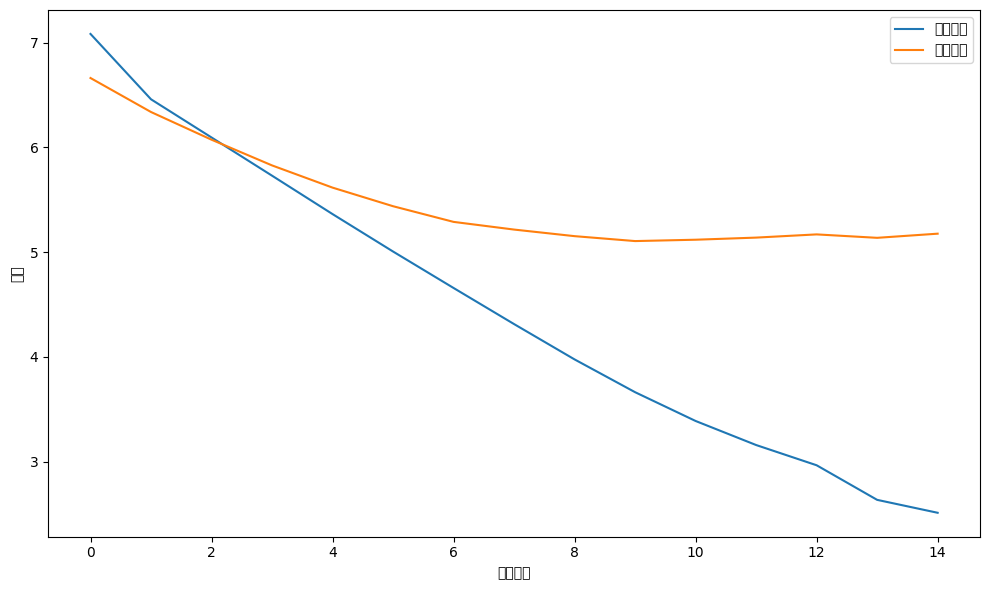

In [18]:
 # 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.xlabel('训练轮次')
plt.ylabel('损失')
plt.legend()
plt.tight_layout()
plt.savefig('transformer_loss_curve.png')
plt.show()

In [21]:
 # 测试翻译示例
model.load_state_dict(torch.load('best_transformer_model.pt', map_location=DEVICE))
model.to(DEVICE)
print("\n测试翻译...")

 # 从验证集取几个样本进行测试
test_samples = random.sample(valid_dataset.data, min(5, len(valid_dataset)))
for i, (src_ids, tgt_ids) in enumerate(test_samples):
    src_text = tokenizer.decode(src_ids.numpy().tolist(), skip_special_tokens=True)
    tgt_text = tokenizer.decode(tgt_ids.numpy().tolist(), skip_special_tokens=True)

    translation_ids = greedy_decode(model, src_ids, MAX_LEN, DEVICE, tokenizer)
    translation = tokenizer.decode(translation_ids[0].cpu().numpy().tolist(), skip_special_tokens=True)

    print(f"\n样本 {i+1}:")
    print(f"原文: {src_text}")
    print(f"真实翻译: {tgt_text}")
    print(f"模型翻译: {translation}")

    # ----- 自定义句子测试 -----
    custom_sentences = [
        "Hello, how are you?",
        "What is your name?",
        "I love learning new things.",
        "The weather is beautiful today.",
        "This is a test of the translation system."
    ]
    print("\n自定义句子翻译测试:")
    for sent in custom_sentences:
        enc = tokenizer.encode(sent)
        src_ids = [tokenizer.token_to_id("<bos>")] + enc.ids[:MAX_LEN - 2] + [tokenizer.token_to_id("<eos>")]
        src_ids = src_ids + [tokenizer.token_to_id("<pad>")] * (MAX_LEN - len(src_ids))
        src_tensor = torch.tensor(src_ids, dtype=torch.long).to(DEVICE)

        translation_ids = greedy_decode(model, src_tensor, MAX_LEN, DEVICE, tokenizer)
        translation = tokenizer.decode(translation_ids[0].cpu().numpy().tolist(), skip_special_tokens=True)

        print(f"原文: {sent}")
        print(f"翻译: {translation}\n")


测试翻译...

样本 1:
原文: They thought he was the son of the Sun .
真实翻译: 他们认为 他是 太阳 之 子 。
模型翻译: 他们 以为 他是 有 志 愿 的 ， 他 民 造 宫 的 顾客 的 ， 所以 他在 商 建 了 。

自定义句子翻译测试:
原文: Hello, how are you?
翻译: 你好 ， 你 开着 ： “ 网络 成瘾 症 ” ， 网 已经 对 网络 是用来 实现 是用来 选 词 。

原文: What is your name?
翻译: 你 网 怎么会 这么 挫折 在 使用 中 ， 观看 时 ， 观看 发生了什么 事情 ， 观看 时 ， 观看 时 ， 观看 时 ， 有的人 轮 实现 是用来 隐藏 了 ？

原文: I love learning new things.
翻译: 我喜欢 一家 专 制 力 拉 罕 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 试图 为了 提高 试图 为了 提高 试图 对 网络 专 专

原文: The weather is beautiful today.
翻译: 今天 天氣 經常 躺在草地上 ， 在 使用 黑暗 中 ， 所以 今天的 激 進 到 各種 各 有 虛 張 手術 。

原文: This is a test of the translation system.
翻译: 这个 网 已经 对 网络 游戏 时 ， 这个 网 译 这个 网 译 这个 网 断 这 对 网络 制 定 人们 对 网络 技术 对 网络 专 门 显示 在 网络 专 制 的 网站 的 网站 员 对 网络 专 门 对 网络 制


样本 2:
原文: Is your school far from your home ?
真实翻译: 你的學校 離 你家 很遠 嗎 ?
模型翻译: 你 上课 时 把 TATOEBA 首 合 的歌 的歌 曲 的 ， 為 不 易 年 以來 ， 有人可以 把 人類 過 在 離譜 的歌 曲 曲 曲 的 。

自定义句子翻译测试:
原文: Hello, how are you?
翻译: 你好 ， 你 开着 ： “ 网络 成瘾 症 